In [1]:
import pickle
import pandas as pd


In [2]:
model_path = open('model/model_classification.pkl', 'rb')
model = pickle.load(model_path)
model

DecisionTreeClassifier()

In [3]:
df = pd.read_csv('data/MSFT_Processed_Data.csv' , parse_dates=['Date'])
df = df.set_index('Date')
df

,Open,High,Low,Close,Adj Close,Volume,change_tmr_%,Tmr_Projection
Date,,,,,,,,
2016-12-09,61.180000,61.990002,61.130001,61.970001,56.274208,27349400,0.321694,UP
2016-12-12,61.820000,62.299999,61.720001,62.169998,56.455818,20198100,1.286125,UP
2016-12-13,62.500000,63.419998,62.240002,62.980000,57.191376,35718900,-0.478620,DOWN
2016-12-14,63.000000,63.450001,62.529999,62.680000,56.918961,30352700,-0.159793,DOWN
2016-12-15,62.700001,63.150002,62.299999,62.580002,56.828140,27669900,-0.449442,DOWN
...,...,...,...,...,...,...,...,...
2024-08-29,414.940002,422.049988,410.600006,413.119995,413.119995,17045200,0.963710,UP
2024-08-30,415.600006,417.489990,412.130005,417.140015,417.140015,24308300,-1.880620,DOWN
2024-09-03,417.910004,419.880005,407.029999,409.440002,409.440002,20285900,-0.132064,DOWN


In [4]:
from backtesting import Backtest, Strategy

In [5]:
predictor = df.drop(columns=['change_tmr_%', 'Tmr_Projection'])
#predictor = predictor.set_index('Date')
predictor.tail(1)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2024-09-05,407.619995,413.100006,406.130005,408.390015,408.390015,14177600


In [6]:
model.predict(predictor.tail(1))[0]

'DOWN'

In [7]:
#modifying the class
class ClassificationUpDown(Strategy):
    def init(self):
        self.model = model
    
    def next(self):
        explanatory_today = predictor.tail(1)
        forecast_tmr = model.predict(explanatory_today)[0]
    

In [8]:
df[ 'Tmr_Projection'].head(10)

Date
2016-12-09      UP
2016-12-12      UP
2016-12-13    DOWN
2016-12-14    DOWN
2016-12-15    DOWN
2016-12-16      UP
2016-12-19    DOWN
2016-12-20    DOWN
2016-12-21      UP
2016-12-22    DOWN
Name: Tmr_Projection, dtype: object

In [9]:
#df = df.drop(columns='buy_sell')
list1 = []
already_bought = False
for tmr in df.Tmr_Projection:
    if tmr == 'UP' and already_bought == False:
        list1.append(1)
        already_bought = True
    elif tmr == 'DOWN' and already_bought == True:
        list1.append(-1)
        already_bought = False
    else:
        list1.append(0)
        
df['buy_sell'] = list1
df[['Tmr_Projection', 'buy_sell']].head()

,Tmr_Projection,buy_sell
Date,,
2016-12-09,UP,1
2016-12-12,UP,0
2016-12-13,DOWN,-1
2016-12-14,DOWN,0
2016-12-15,DOWN,0


In [10]:
df[[ 'Tmr_Projection', 'buy_sell']].head()

,Tmr_Projection,buy_sell
Date,,
2016-12-09,UP,1
2016-12-12,UP,0
2016-12-13,DOWN,-1
2016-12-14,DOWN,0
2016-12-15,DOWN,0


In [11]:
class ClassificationUpDown(Strategy):
    def init(self):
        self.model = model
        self.already_bought = False
    
    def next(self):
        explanatory_today = self.data.df.tail(1)
        forecast_tmr = model.predict(explanatory_today)[0]
        if forecast_tmr == 'UP' and self.already_bought == False:
            self.buy()
            self.already_bought = True
        elif forecast_tmr == 'DOWN' and self.already_bought == True:
            self.sell()
            self.already_bought = False
        else:
            pass

In [22]:
bt = Backtest(data = predictor, strategy=ClassificationUpDown, cash=10000, commission=.002, exclusive_orders=True )
result1 = bt.run()
result = result1.to_frame(name='Value')
result

,Value
Start,2016-12-09 00:00:00
End,2024-09-05 00:00:00
Duration,2827 days 00:00:00
Exposure Time [%],99.897225
Equity Final [$],4824355873.404067
Equity Peak [$],4824355873.404067
Return [%],48243458.734041
Buy & Hold Return [%],559.012436
Return (Ann.) [%],444.483784
Volatility (Ann.) [%],128.110575


<Axes: xlabel='Date'>

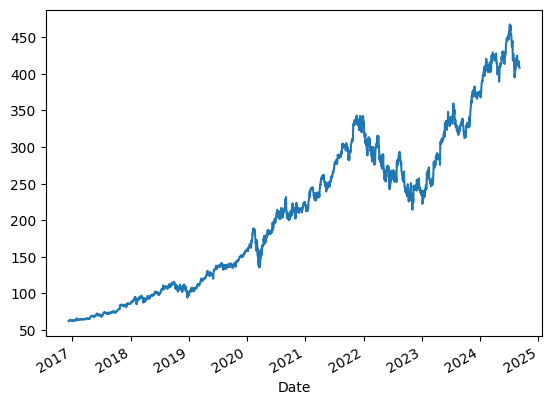

In [16]:
df.Close.plot()